In [155]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [156]:
train_raw = pd.read_csv('./input data/train.csv')
test_raw = pd.read_csv('./input data/test.csv')

train_ids = train_raw['id']
train_y = train_raw['failure']
train_x = train_raw.drop(['id', 'failure'], axis='columns')

test_ids = test_raw['id']
test_x = test_raw.drop(['id'], axis='columns')

In [157]:
categorical_columns = ['product_code', 'attribute_0', 'attribute_1', 'attribute_2', 'attribute_3']

for column in categorical_columns:
    train_x[column] = pd.factorize(train_x[column])[0]
    test_x[column] = pd.factorize(test_x[column])[0]


In [158]:
print( np.sum(np.isnan( train_x.drop(categorical_columns, axis='columns')), axis=0 ))
print( np.sum(np.isnan( test_x.drop(categorical_columns, axis='columns')), axis=0 ))

loading            250
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      381
measurement_4      538
measurement_5      676
measurement_6      796
measurement_7      937
measurement_8     1048
measurement_9     1227
measurement_10    1300
measurement_11    1468
measurement_12    1601
measurement_13    1774
measurement_14    1874
measurement_15    2009
measurement_16    2110
measurement_17    2284
dtype: int64
loading            223
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      329
measurement_4      409
measurement_5      508
measurement_6      624
measurement_7      720
measurement_8      846
measurement_9      904
measurement_10    1067
measurement_11    1136
measurement_12    1240
measurement_13    1303
measurement_14    1440
measurement_15    1542
measurement_16    1678
measurement_17    1740
dtype: int64


In [163]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer()
train_x = imp.fit_transform(train_x)
test_x = imp.transform(test_x)


In [164]:
from sklearn.ensemble import IsolationForest

outlier_detector = IsolationForest()
results = outlier_detector.fit_predict(train_x)

-1804


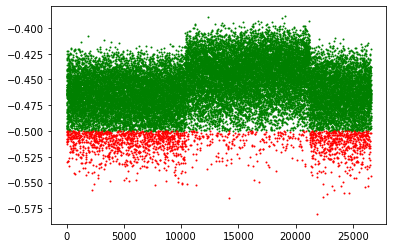

In [165]:
scores = outlier_detector.score_samples(train_x)
plt.scatter(train_ids[results>0], scores[results>0], c='green', s=1)
plt.scatter(train_ids[results<0], scores[results<0], c='red', s=1)
print(np.sum(results[results<0], axis=0))

In [166]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer()
scaled_train_x = scaler.fit_transform(train_x)
scaled_test_x = scaler.transform(test_x)

scaled_outlier_detector = IsolationForest()
scaled_results = scaled_outlier_detector.fit_predict(train_x)

-1860


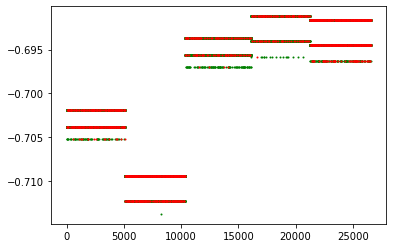

In [167]:
scaled_scores = scaled_outlier_detector.score_samples(scaled_train_x)
plt.scatter(train_ids[scaled_results>0], scaled_scores[scaled_results>0], c='green', s=1)
plt.scatter(train_ids[scaled_results<0], scaled_scores[scaled_results<0], c='red', s=1)
print(np.sum(scaled_results[scaled_results<0], axis=0))

In [168]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standard_train_x = scaler.fit_transform(train_x)
standard_test_x = scaler.transform(test_x)

standard_outlier_detector = IsolationForest()
standard_results = standard_outlier_detector.fit_predict(train_x)

-1676


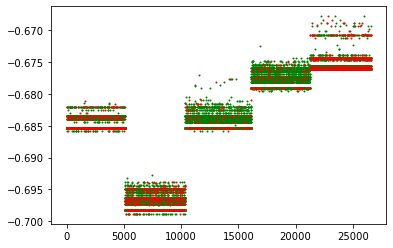

In [169]:
standard_scores = standard_outlier_detector.score_samples(standard_train_x)
plt.scatter(train_ids[standard_results>0], standard_scores[standard_results>0], c='green', s=1)
plt.scatter(train_ids[standard_results<0], standard_scores[standard_results<0], c='red', s=1)
print(np.sum(standard_results[standard_results<0], axis=0))

In [176]:
from sklearn.model_selection import GroupKFold
kf = GroupKFold(n_splits=5)
folds = kf.split(train_x, train_y, train_x[:, 0])

In [177]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

param_grid = dict()
param_grid['n_estimators'] = [100]
param_grid['max_depth'] = np.arange(1, 5)
param_grid['ccp_alpha'] = np.arange(0, 0.05, 0.01)

pipe = Pipeline([('gs', RandomForestClassifier(n_jobs=-1))])
pipe.fit(train_x, train_y)
print(pipe['gs'].best_score_)
print(pipe['gs'].best_params_)

AttributeError: 'RandomForestClassifier' object has no attribute 'best_score_'

In [147]:
scaled_param_grid = dict()
scaled_param_grid['n_estimators'] = [100]
scaled_param_grid['max_depth'] = np.arange(1, 5)
scaled_param_grid['ccp_alpha'] = np.arange(0, 0.05, 0.01)

scaled_pipe = Pipeline([('scaler', QuantileTransformer()),
    ('gs', GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1), param_grid=scaled_param_grid, scoring='f1', n_jobs=-1))])
scaled_pipe.fit(train_x, train_y)
print(scaled_pipe['gs'].best_score_)
print(scaled_pipe['gs'].best_params_)

0.07285045975157284
{'ccp_alpha': 0.0, 'max_depth': 2, 'n_estimators': 100}


In [148]:
standard_param_grid = dict()
standard_param_grid['n_estimators'] = [100]
standard_param_grid['max_depth'] = np.arange(1, 5)
standard_param_grid['ccp_alpha'] = np.arange(0, 0.05, 0.01)

standard_pipe = Pipeline([('scaler', StandardScaler()),
    ('gs', GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1), param_grid=standard_param_grid, scoring='f1', n_jobs=-1))])
standard_pipe.fit(train_x, train_y)
print(standard_pipe['gs'].best_score_)
print(standard_pipe['gs'].best_params_)

0.07285045975157284
{'ccp_alpha': 0.0, 'max_depth': 2, 'n_estimators': 100}


In [105]:
predictions = pipe.predict(test_x)
final_result = pd.DataFrame()
final_result['id'] = test_ids
final_result['failure'] = predictions

In [106]:
print(np.sum(final_result, axis=0))
print(final_result.head())

id         767781675
failure            0
dtype: int64
      id  failure
0  26570        0
1  26571        0
2  26572        0
3  26573        0
4  26574        0


In [111]:
from sklearn.linear_model import LogisticRegression

logreg_param_grid = dict()
logreg_param_grid['penalty'] = ['l2', 'none']
logreg_param_grid['C'] = np.arange(1, 50, 5)


logreg_pipe = Pipeline([('gs', GridSearchCV(estimator=LogisticRegression(max_iter=1000), param_grid=logreg_param_grid, scoring='f1', n_jobs=-1))])
logreg_pipe.fit(train_x, train_y)

print(logreg_pipe['gs'].best_score_)
print(logreg_pipe['gs'].best_params_)

0.02447544055979867
{'C': 1, 'penalty': 'l2'}


In [143]:
logreg_scaled_pipe = Pipeline([('scaler', QuantileTransformer()),
    ('gs', GridSearchCV(estimator=LogisticRegression(max_iter=100), param_grid=logreg_param_grid, scoring='f1',  n_jobs=-1))])
logreg_scaled_pipe.fit(train_x, train_y)

print(logreg_scaled_pipe['gs'].best_score_)
print(logreg_scaled_pipe['gs'].best_params_)

0.1445633107837469
{'C': 6, 'penalty': 'l2'}


In [115]:
logreg_standard_pipe = Pipeline([('scaler', StandardScaler()),
    ('gs', GridSearchCV(estimator=LogisticRegression(max_iter=1000), param_grid=logreg_param_grid, scoring='f1', n_jobs=-1))])
logreg_standard_pipe.fit(train_x, train_y)

print(logreg_standard_pipe['gs'].best_score_)
print(logreg_standard_pipe['gs'].best_params_)

0.14336202573059045
{'C': 6, 'penalty': 'l2'}


In [144]:
logreg_predictions = logreg_scaled_pipe.predict(scaled_test_x)
logreg_final_result = pd.DataFrame()
logreg_final_result['id'] = test_ids
logreg_final_result['failure'] = logreg_predictions
logreg_final_result.to_csv('logreg_predictions.csv', header=True, index=False)

In [145]:
print(np.sum(logreg_final_result, axis=0))
print(logreg_final_result.head())

id         767781675
failure            0
dtype: int64
      id  failure
0  26570        0
1  26571        0
2  26572        0
3  26573        0
4  26574        0


In [142]:
print(logreg_scaled_pipe['gs'].decision_function(scaled_train_x))

[-1.65789894 -1.68124888 -1.67519969 ... -1.46009978 -1.55358245
 -1.37776592]
